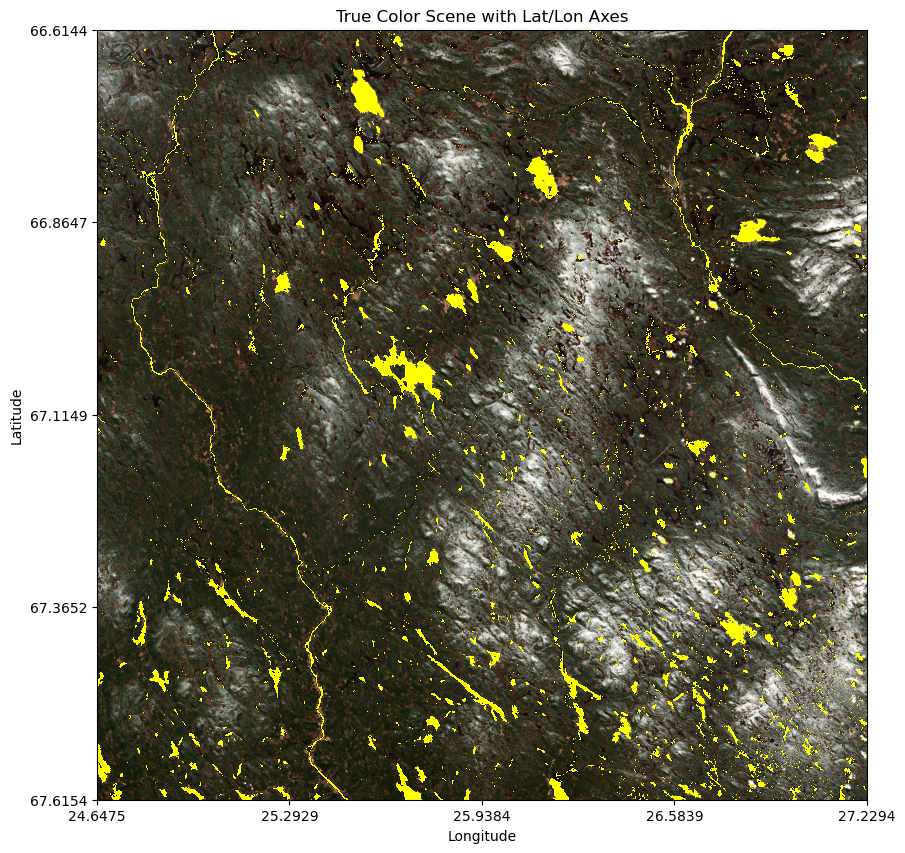

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
from pyproj import Transformer
from matplotlib.colors import ListedColormap

# Define paths for Sentinel-2 and DEM files
sentinel_path = "../data_store/data/S2B_MSIL2A_20230515T095559_N0509_R122_T35WMQ_20230515T113307.SAFE/GRANULE/L2A_T35WMQ_A032323_20230515T095746/IMG_DATA/R20m/"
dem_base_path = "../data_store/data/korkeusmalli/hila_2m/etrs-tm35fin-n2000/U4/"

# Define Sentinel-2 Band files
band12_file = sentinel_path + "T35WMQ_20230515T095559_B12_20m.jp2"  # SWIR
band8a_file = sentinel_path + "T35WMQ_20230515T095559_B8A_20m.jp2"  # NIR
band4_file = sentinel_path + "T35WMQ_20230515T095559_B04_20m.jp2"   # Red
band3_file = sentinel_path + "T35WMQ_20230515T095559_B03_20m.jp2"   # Green
band2_file = sentinel_path + "T35WMQ_20230515T095559_B02_20m.jp2"   # Blue

# Load Sentinel-2 bands and DEM data
def load_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs, src

# Load the Sentinel-2 bands
band12, transform_band12, crs_band12, src_band12 = load_raster(band12_file)
band8a, transform_band8a, crs_band8a, src_band8a = load_raster(band8a_file)
band4, transform_band4, crs_band4, src_band4 = load_raster(band4_file)
band3, transform_band3, crs_band3, src_band3 = load_raster(band3_file)
band2, transform_band2, crs_band2, src_band2 = load_raster(band2_file)

# List all DEM files and dynamically assign the correct folder (U43 or U44)
dem_file_names = [
    "U4341G.tif", "U4341H.tif", "U4342G.tif", "U4342H.tif",
    "U4343A.tif", "U4343B.tif", "U4343C.tif", "U4343D.tif", "U4343E.tif", "U4343F.tif", "U4343G.tif", "U4343H.tif",
    "U4344A.tif", "U4344B.tif", "U4344C.tif", "U4344D.tif", "U4344E.tif", "U4344F.tif", "U4344G.tif", "U4344H.tif",
    "U4431G.tif", "U4433A.tif", "U4433C.tif", "U4433E.tif", "U4433G.tif"
]

# Function to assign correct folder based on file name prefix
def get_dem_path(filename):
    if filename.startswith("U43"):
        return dem_base_path + "U43/" + filename
    elif filename.startswith("U44"):
        return dem_base_path + "U44/" + filename
    else:
        raise ValueError(f"Unexpected DEM file name: {filename}")

# Generate full paths for each DEM file
dem_files = [get_dem_path(fname) for fname in dem_file_names]

# Load and merge DEM files
def merge_dems(dem_files):
    dem_list = []
    for file in dem_files:
        dem, transform_dem, crs_dem, src_dem = load_raster(file)
        dem_list.append(dem)
    merged_dem = np.maximum.reduce(dem_list)  # Simple maximum operation to merge DEMs
    return merged_dem, transform_dem, crs_dem

# Merge all DEMs
dem_combined, transform_dem_combined, crs_dem_combined = merge_dems(dem_files)

# Reproject DEM to match Sentinel-2 CRS and resolution (Band 12 for reference)
def reproject_raster(src_array, src_transform, src_crs, dst_transform, dst_crs, dst_shape, resampling=Resampling.nearest):
    dst_array = np.empty(dst_shape, dtype=src_array.dtype)
    reproject(
        source=src_array,
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=resampling
    )
    return dst_array

# Reproject the DEM to match the Sentinel-2 data (SWIR band reference)
dem_reprojected = reproject_raster(
    dem_combined,
    transform_dem_combined,
    crs_dem_combined,
    transform_band12,
    crs_band12,
    band12.shape
)

# Function to apply contrast stretching
def contrast_stretch(band, low_perc=2, high_perc=98):
    """
    Stretch the image contrast by clipping pixel values based on percentiles.
    """
    low = np.percentile(band, low_perc)
    high = np.percentile(band, high_perc)
    stretched_band = np.clip(band, low, high)
    stretched_band = (stretched_band - low) / (high - low) * 255  # Rescale to 0-255
    return stretched_band

# Create true color composite using bands 4, 3, and 2 with contrast adjustment
def create_true_color_composite(band4, band3, band2, apply_stretch=True):
    if apply_stretch:
        band4 = contrast_stretch(band4)
        band3 = contrast_stretch(band3)
        band2 = contrast_stretch(band2)

    # Stack the bands into a single composite image
    composite = np.dstack((band4, band3, band2))
    return composite.astype(np.uint8)  # Convert to 8-bit format

# Create SWIR composite using bands 12, 8A, and 4 (for visualization)
def create_swir_composite(band12, band8a, band4):
    composite = np.dstack((band12, band8a, band4))
    return composite

def create_mask(swir_composite):
    """
    Generates a mask where active areas are marked and inactive areas are set to NaN.
    """
    # Thresholds based on the description of the features
    water_marsh_mask = ((swir_composite[:, :, 0] < 1200))  # Dark in SWIR (water/marsh)
    cloud_mask = (swir_composite[:, :, 0] > 5000) & (swir_composite[:, :, 1] > 5000) & (swir_composite[:, :, 2] > 5000)  # White clouds
    
    # Combine all masks
    combined_mask = np.logical_or.reduce([water_marsh_mask, cloud_mask])
    #print(combined_mask)
    
    # Set mask to NaN where it's not active, and 1 where it is active
    combined_mask = np.where(combined_mask, 1, np.nan)
    
    return combined_mask

# Convert pixel coordinates to lat/lon (EPSG:4326)
def pixel_to_latlon(transform, crs, width, height):
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    xs, ys = np.meshgrid(np.arange(width), np.arange(height))
    lon, lat = rasterio.transform.xy(transform, ys, xs, offset='center')
    lon = np.array(lon)
    lat = np.array(lat)
    lon_lat_transformed = np.vectorize(lambda x, y: transformer.transform(x, y))(lon, lat)
    return lon_lat_transformed[0], lon_lat_transformed[1]

# Visualize the SWIR composite and the mask
def plot_image(image, title, cmap='gray'):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap=cmap, interpolation='none')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Plot true color image with bright yellow mask overlay
def plot_true_color_with_mask(true_color_composite, mask=None, transform=None, crs=None, title="True Color Image"):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(true_color_composite)

    # Define a hard yellow colormap (banana yellow)
    banana_yellow = ListedColormap(['yellow'])

    # Overlay the mask in bright yellow, where the mask is active (mask != NaN)
    if mask is not None:
        ax.imshow(mask, cmap=banana_yellow, alpha=1, interpolation='none')  # Apply hard banana yellow with full alpha
    
    if transform is not None and crs is not None:
        lon, lat = pixel_to_latlon(transform, crs, true_color_composite.shape[1], true_color_composite.shape[0])
        ax.set_xticks(np.linspace(0, true_color_composite.shape[1], 5))
        ax.set_yticks(np.linspace(0, true_color_composite.shape[0], 5))
        ax.set_xticklabels(np.round(np.linspace(np.min(lon), np.max(lon), 5), 4))
        ax.set_yticklabels(np.round(np.linspace(np.min(lat), np.max(lat), 5), 4))
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
    
    ax.set_title(title)
    plt.show()

# Create SWIR composite and mask (if needed)
swir_composite = create_swir_composite(band12, band8a, band4)
mask = create_mask(swir_composite)  # Mask generation (can be omitted if not needed)

# # Show the mask
# plot_image(mask, 'Mask for Lakes, Marshes, Icy Lakes, and Clouds', cmap='gray')

# Create the true color composite with contrast adjustment
true_color_composite = create_true_color_composite(band4, band3, band2, apply_stretch=True)

# Plot true color scene with optional mask overlay
plot_true_color_with_mask(true_color_composite, mask=mask, transform=transform_band4, crs=crs_band4, title="True Color Scene with Lat/Lon Axes")


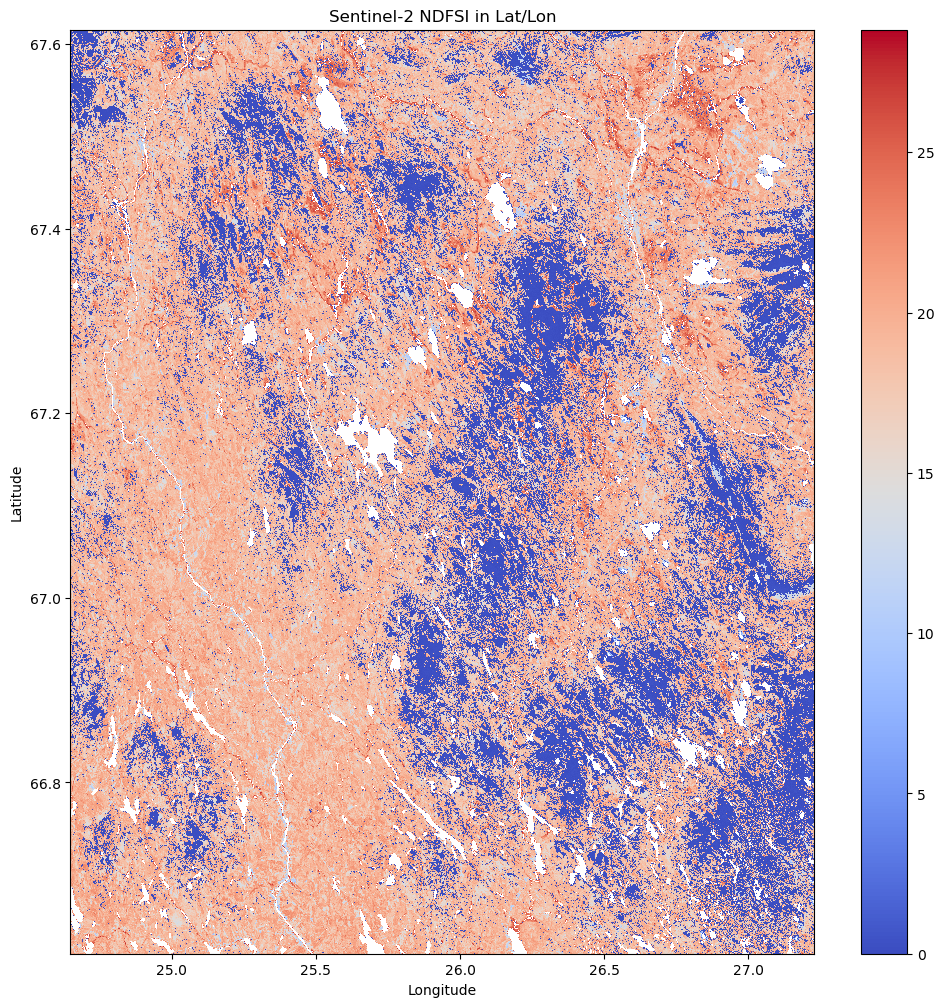

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pyproj import Transformer

def calculate_ndfsi(green_band, swir_band):
    """
    Calculate the NDFSI using Green (Band 3) and SWIR (Band 12).
    """
    ndfsi = (green_band - swir_band) / (green_band + swir_band)
    return ndfsi

def apply_mask(ndfsi, mask):
    """
    Apply the mask to the NDFSI array. Masked areas will be set to NaN.
    """
    # Set NDFSI values where the mask is NaN to the NDFSI value, and everything else to NaN
    masked_ndfsi = np.where(np.isnan(mask), ndfsi, np.nan)
    return masked_ndfsi

def pixel_to_latlon(transform, crs, width, height):
    """
    Convert pixel coordinates to latitude/longitude coordinates (EPSG:4326).
    """
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    xs, ys = np.meshgrid(np.arange(width), np.arange(height))
    lon, lat = rasterio.transform.xy(transform, ys, xs, offset='center')
    lon = np.array(lon)
    lat = np.array(lat)
    lon_lat_transformed = np.vectorize(lambda x, y: transformer.transform(x, y))(lon, lat)
    return lon_lat_transformed[0], lon_lat_transformed[1]

def plot_ndfsi_latlon(ndfsi, transform, crs, title="Sentinel-2 NDFSI in Lat/Lon"):
    """
    Plot the NDFSI with latitude/longitude coordinates.
    """
    # Convert pixel coordinates to latitude and longitude
    lon, lat = pixel_to_latlon(transform, crs, ndfsi.shape[1], ndfsi.shape[0])
    
    # Calculate the aspect ratio based on the dimensions of the NDFSI array
    aspect_ratio = ndfsi.shape[0] / ndfsi.shape[1]
    
    # Plotting the NDFSI with lat/lon coordinates
    plt.figure(figsize=(12, 12 * aspect_ratio))
    plt.imshow(ndfsi, extent=(lon.min(), lon.max(), lat.min(), lat.max()), cmap='coolwarm', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.show()

# Load Sentinel-2 bands (Band 3 - Green, Band 12 - SWIR)
green_band, transform_band3, crs_band3, _ = load_raster(band3_file)
swir_band, transform_band12, crs_band12, _ = load_raster(band12_file)

# Calculate the NDFSI using Bands 3 and 12
ndfsi = calculate_ndfsi(green_band, swir_band)

# Create the mask using SWIR composite (assumed to be defined earlier)
mask = create_mask(swir_composite)

# Apply the mask to the NDFSI to ignore masked areas
masked_ndfsi = apply_mask(ndfsi, mask)

# Plot the NDFSI with latitude/longitude coordinates
plot_ndfsi_latlon(masked_ndfsi, transform_band3, crs_band3, title="Sentinel-2 NDFSI in Lat/Lon")


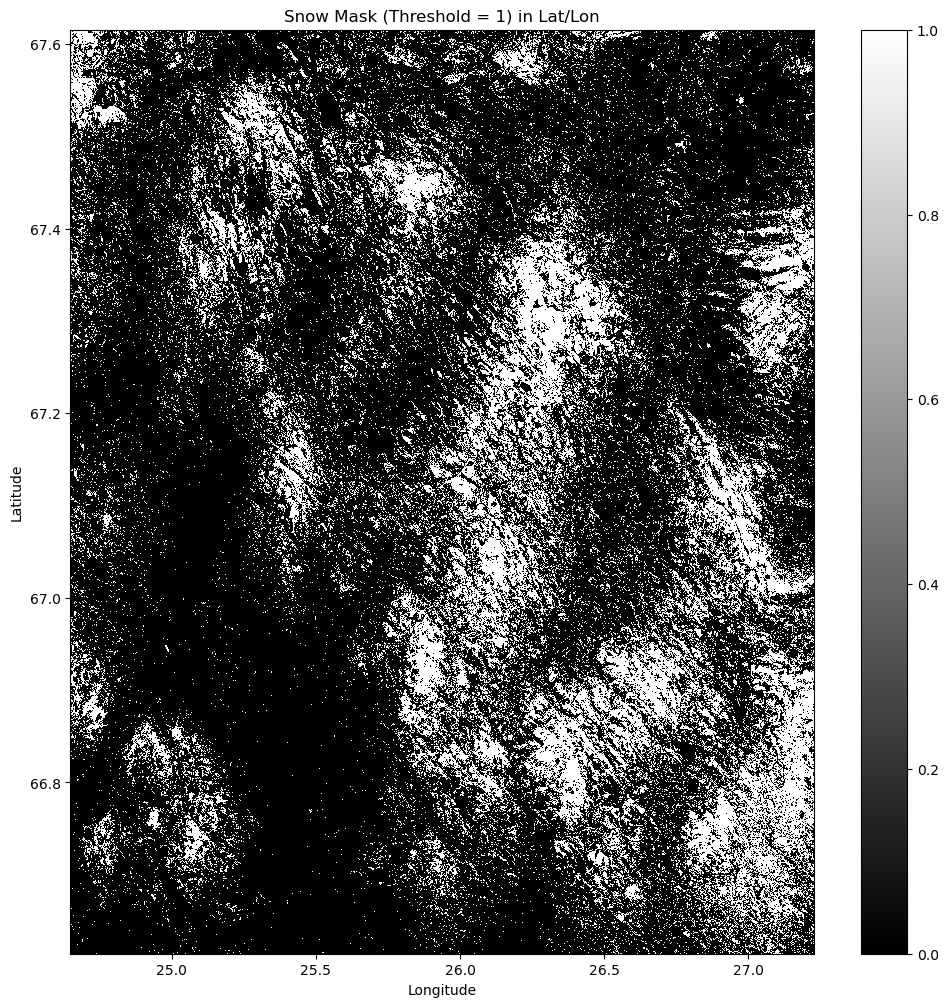

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer

def apply_snow_threshold(ndfsi, threshold):
    """
    Apply a snow threshold to the NDFSI. 
    Below the threshold, set values to 1 (snow), and above it, set to 0 (no snow).
    """
    snow_mask = np.where(ndfsi <= threshold, 1, 0)
    return snow_mask

def pixel_to_latlon(transform, crs, width, height):
    """
    Convert pixel coordinates to latitude/longitude coordinates (EPSG:4326).
    """
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    xs, ys = np.meshgrid(np.arange(width), np.arange(height))
    lon, lat = rasterio.transform.xy(transform, ys, xs, offset='center')
    lon = np.array(lon)
    lat = np.array(lat)
    lon_lat_transformed = np.vectorize(lambda x, y: transformer.transform(x, y))(lon, lat)
    return lon_lat_transformed[0], lon_lat_transformed[1]

def plot_single_snow_mask_latlon(ndfsi, threshold, transform, crs):
    """
    Plot a single snow mask for a given threshold in latitude/longitude, preserving aspect ratio.
    """
    snow_mask = apply_snow_threshold(ndfsi, threshold)
    
    # Convert pixel coordinates to latitude and longitude
    lon, lat = pixel_to_latlon(transform, crs, snow_mask.shape[1], snow_mask.shape[0])
    
    # Calculate the aspect ratio based on the dimensions of the NDFSI array
    aspect_ratio = snow_mask.shape[0] / snow_mask.shape[1]
    
    # Plotting the snow mask with lat/lon coordinates
    plt.figure(figsize=(12, 12 * aspect_ratio))
    plt.imshow(snow_mask, extent=(lon.min(), lon.max(), lat.min(), lat.max()), cmap='gray', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Snow Mask (Threshold = {threshold}) in Lat/Lon')
    plt.show()

# Set the threshold to 1
threshold = 1

# Plot the snow mask based on the chosen threshold with latitude/longitude coordinates and proper scaling
plot_single_snow_mask_latlon(masked_ndfsi, threshold, transform_band4, crs_band4)


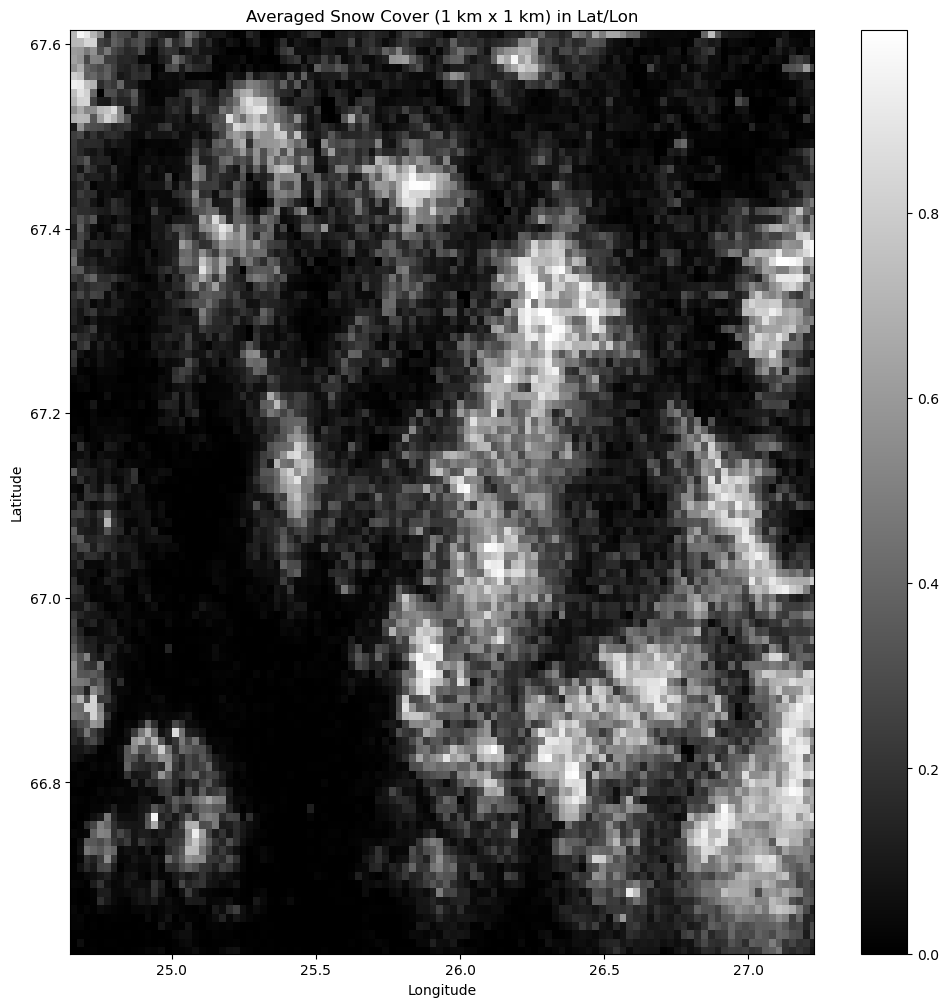

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer

def apply_snow_threshold(ndfsi, threshold):
    """
    Apply a snow threshold to the NDFSI. 
    Below the threshold, set values to 1 (snow), and above it, set to 0 (no snow).
    """
    snow_mask = np.where(ndfsi <= threshold, 1, 0)
    return snow_mask

def pixel_to_latlon(transform, crs, width, height):
    """
    Convert pixel coordinates to latitude/longitude coordinates (EPSG:4326).
    """
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    xs, ys = np.meshgrid(np.arange(width), np.arange(height))
    lon, lat = rasterio.transform.xy(transform, ys, xs, offset='center')
    lon = np.array(lon)
    lat = np.array(lat)
    lon_lat_transformed = np.vectorize(lambda x, y: transformer.transform(x, y))(lon, lat)
    return lon_lat_transformed[0], lon_lat_transformed[1]

def average_snow_cover_in_blocks(snow_mask, transform, block_size_meters=1000):
    """
    Calculate the fractional snow cover in 1 km x 1 km blocks.
    """
    pixel_size_x = abs(transform[0])
    pixel_size_y = abs(transform[4])

    # Calculate the number of pixels that correspond to the block size (1 km x 1 km)
    block_size_x = int(block_size_meters / pixel_size_x)
    block_size_y = int(block_size_meters / pixel_size_y)
    
    # Get the dimensions of the snow mask
    rows, cols = snow_mask.shape
    
    # Initialize an array for the averaged snow cover
    averaged_snow_cover = np.full_like(snow_mask, np.nan, dtype=float)
    
    # Iterate over the blocks
    for i in range(0, rows, block_size_y):
        for j in range(0, cols, block_size_x):
            # Extract the block
            block = snow_mask[i:i+block_size_y, j:j+block_size_x]
            
            # Calculate the mean of the block, ignoring NaNs
            if np.isnan(block).all():
                block_mean = np.nan
            else:
                block_mean = np.nanmean(block)
            
            # Assign the mean value to the entire block
            averaged_snow_cover[i:i+block_size_y, j:j+block_size_x] = block_mean
    
    return averaged_snow_cover

def plot_averaged_snow_cover_latlon(averaged_snow_cover, transform, crs, title="Averaged Snow Cover (1 km x 1 km)"):
    """
    Plot the averaged snow cover with latitude/longitude coordinates.
    """
    # Convert pixel coordinates to latitude and longitude
    lon, lat = pixel_to_latlon(transform, crs, averaged_snow_cover.shape[1], averaged_snow_cover.shape[0])
    
    # Calculate the aspect ratio based on the dimensions of the averaged snow cover array
    aspect_ratio = averaged_snow_cover.shape[0] / averaged_snow_cover.shape[1]
    
    # Plotting the averaged snow cover with lat/lon coordinates
    plt.figure(figsize=(12, 12 * aspect_ratio))
    plt.imshow(averaged_snow_cover, extent=(lon.min(), lon.max(), lat.min(), lat.max()), cmap='gray', interpolation='none', aspect='auto')
    plt.colorbar()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(title)
    plt.show()

# Set the threshold to 1
threshold = 1

# Apply the threshold to create a binary snow mask
snow_mask = apply_snow_threshold(masked_ndfsi, threshold)

# Calculate the averaged snow cover in 1 km x 1 km blocks
averaged_snow_cover = average_snow_cover_in_blocks(snow_mask, transform_band4)

# Plot the averaged snow cover with latitude/longitude coordinates
plot_averaged_snow_cover_latlon(averaged_snow_cover, transform_band4, crs_band4, title="Averaged Snow Cover (1 km x 1 km) in Lat/Lon")
